In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
#Set data order
data_order = 8

In [3]:
# wandb.init(project="ads1_prj_VGG19n")


In [4]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [5]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder()
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [8]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # Dữ liệu label đã được mã hóa
# def oneHot(arr):
#     labels = np.array(arr)
#     # Khởi tạo một trình chuyển đổi OneHotEncoder
#     encoder = OneHotEncoder(sparse=False)
    
#     # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
#     labels_reshaped = labels.reshape(-1, 1)
    
#     # Fit trình chuyển đổi vào dữ liệu
#     encoder.fit(labels_reshaped)
    
#     # Chuyển đổi labels sang dạng one-hot encoding
#     onehot_labels = encoder.transform(labels_reshaped)
#     return onehot_labels

# y_train=oneHot(y_train)
# y_test=oneHot(y_test)

In [9]:
x_test.shape

(330, 42)

In [10]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [11]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [12]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [13]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [14]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    # Convert predictions to binary (0 or 1)
    y_pred = K.round(y_pred)
    
    # Calculate True Positives, False Positives and False Negatives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    
    # Calculate precision and recall for each class
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    
    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [17]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Reshape, GlobalAveragePooling1D,MaxPooling1D,Dense,AveragePooling1D
from keras.models import Model
from keras import layers

from keras.layers import Layer
from keras import backend as K


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv1d_bn(x,
              filters,
              kernel_size,
              padding='same',
              strides=1,
              name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 1
    x = Conv1D(
        filters, kernel_size,
        strides=strides,
        padding=str(padding),
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [18]:
def InceptionV3():
    # Determine proper input shape
    input_shape = (42,1)
    x_input = Input(shape=input_shape)
    channel_axis = -1

    x = conv1d_bn(x_input, 32, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 32, 3, padding='valid')
    x = conv1d_bn(x, 64, 3, padding='valid')
    x = MaxPooling1D(3, strides=2, name="block1_pool")(x)
    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')

    branch5x5 = conv1d_bn(x, 48,1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')
    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 32, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')
    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64,5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64, 1,padding='same')

    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv1d_bn(x, 128, 3, strides=2, padding='valid')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(
        branch3x3dbl, 96, 3, strides=2, padding='valid')

    branch_pool = MaxPooling1D(3, strides=2)(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 128, 1,padding='same')

    branch7x7 = conv1d_bn(x, 96, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 96, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 128, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 96, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 128, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 128, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # # mixed 5, 6: 17 x 17 x 768
    # for i in range(2):
    #     branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    #     branch7x7 = conv1d_bn(x, 160, 1,padding='same')
    #     branch7x7 = conv1d_bn(branch7x7, 160, 1,padding='same')
    #     branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    #     branch7x7dbl = conv1d_bn(x, 160, 1,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 1,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    #     branch_pool = AveragePooling1D(
    #         3, strides=1, padding='same')(x)
    #     branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    #     x = layers.concatenate(
    #         [branch1x1, branch7x7, branch7x7dbl, branch_pool],
    #         axis=channel_axis,
    #         name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    branch7x7 = conv1d_bn(x, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 192, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')
    # branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    # branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # # mixed 8: 8 x 8 x 960
    # branch3x3 = conv1d_bn(x, 192, 1,padding='same')
    # branch3x3 = conv1d_bn(branch3x3, 288, 3,
    #                       strides=2, padding='valid')

    # branch7x7x3 = conv1d_bn(x, 192, 1,padding='same')
    # branch7x7x3 = conv1d_bn(branch7x7x3, 192, 1,padding='same')
    # branch7x7x3 = conv1d_bn(branch7x7x3, 192, 7,padding='same')
    # branch7x7x3 = conv1d_bn(
    #     branch7x7x3, 192, 3, strides=2, padding='valid')

    # branch_pool = MaxPooling1D(3, strides=2)(x)
    # x = layers.concatenate(
    #     [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # # mixed 9: 8 x 8 x 2048
    # for i in range(2):
    #     branch1x1 = conv1d_bn(x, 288, 1,padding='same')

    #     branch3x3 = conv1d_bn(x, 256, 1,padding='same')
    #     branch3x3_1 = conv1d_bn(branch3x3, 256, 1,padding='same')
    #     branch3x3_2 = conv1d_bn(branch3x3, 256, 3,padding='same')
    #     branch3x3 = layers.concatenate(
    #         [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

    #     branch3x3dbl = conv1d_bn(x, 448, 1,padding='same')
    #     branch3x3dbl = conv1d_bn(branch3x3dbl, 256, 3,padding='same')
    #     branch3x3dbl_1 = conv1d_bn(branch3x3dbl, 256, 1,padding='same')
    #     branch3x3dbl_2 = conv1d_bn(branch3x3dbl, 256, 3,padding='same')
    #     branch3x3dbl = layers.concatenate(
    #         [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    #     branch_pool = AveragePooling1D(
    #         3, strides=1, padding='same')(x)
    #     branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    #     x = layers.concatenate(
    #         [branch1x1, branch3x3, branch3x3dbl, branch_pool],
    #         axis=channel_axis,
    #         name='mixed' + str(9 + i))
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)

    # Create model.
    model = Model(x_input, x, name='inception_v3')
    return model


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

model = InceptionV3()
# lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)


model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 20, 32)               96        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 20, 32)               60        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 20, 32)               0         ['batch_normalizati

In [19]:
model.fit(dict_data[data_order][0],dict_data[data_order][1].toarray(),
          validation_data=(dict_data[data_order][2],dict_data[data_order][3].toarray()),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback],class_weight={0: 0.654690618762475, 1: 2.1161290322580646})

Epoch 1/10000
15/16 [===========================>..] - ETA: 0s - loss: 1.5410 - accuracy: 0.4927 - f1_score: 0.3291
Epoch 1: val_f1_score improved from -inf to 0.42467, saving model to best_model.h5
16/16 [==============================] - 12s 113ms/step - loss: 1.5094 - accuracy: 0.4900 - f1_score: 0.3272 - val_loss: 0.6230 - val_accuracy: 0.7377 - val_f1_score: 0.4247 - lr: 0.0010
Epoch 2/10000
15/16 [===========================>..] - ETA: 0s - loss: 0.7834 - accuracy: 0.5000 - f1_score: 0.3330
Epoch 2: val_f1_score did not improve from 0.42467
16/16 [==============================] - 1s 33ms/step - loss: 0.7822 - accuracy: 0.5000 - f1_score: 0.3330 - val_loss: 0.9531 - val_accuracy: 0.2623 - val_f1_score: 0.2054 - lr: 0.0010
Epoch 3/10000
15/16 [===========================>..] - ETA: 0s - loss: 0.7574 - accuracy: 0.5010 - f1_score: 0.3331
Epoch 3: val_f1_score improved from 0.42467 to 0.54484, saving model to best_model.h5
16/16 [==============================] - 1s 47ms/step - loss

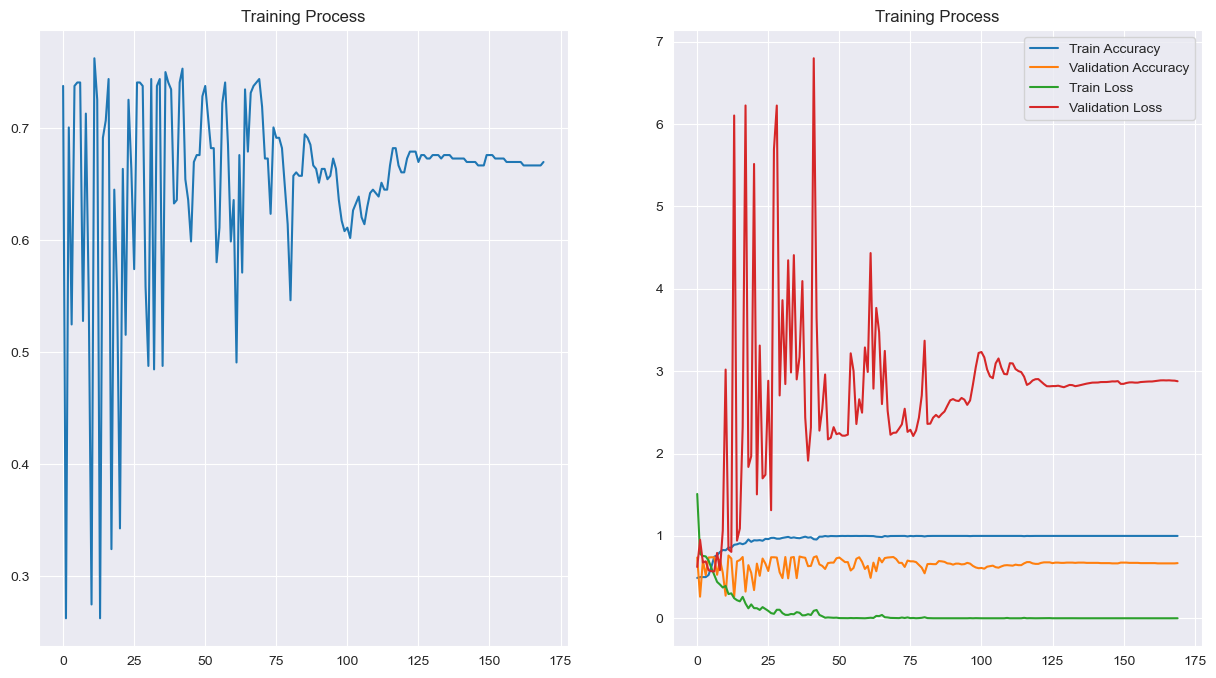

<Figure size 640x480 with 0 Axes>

In [20]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

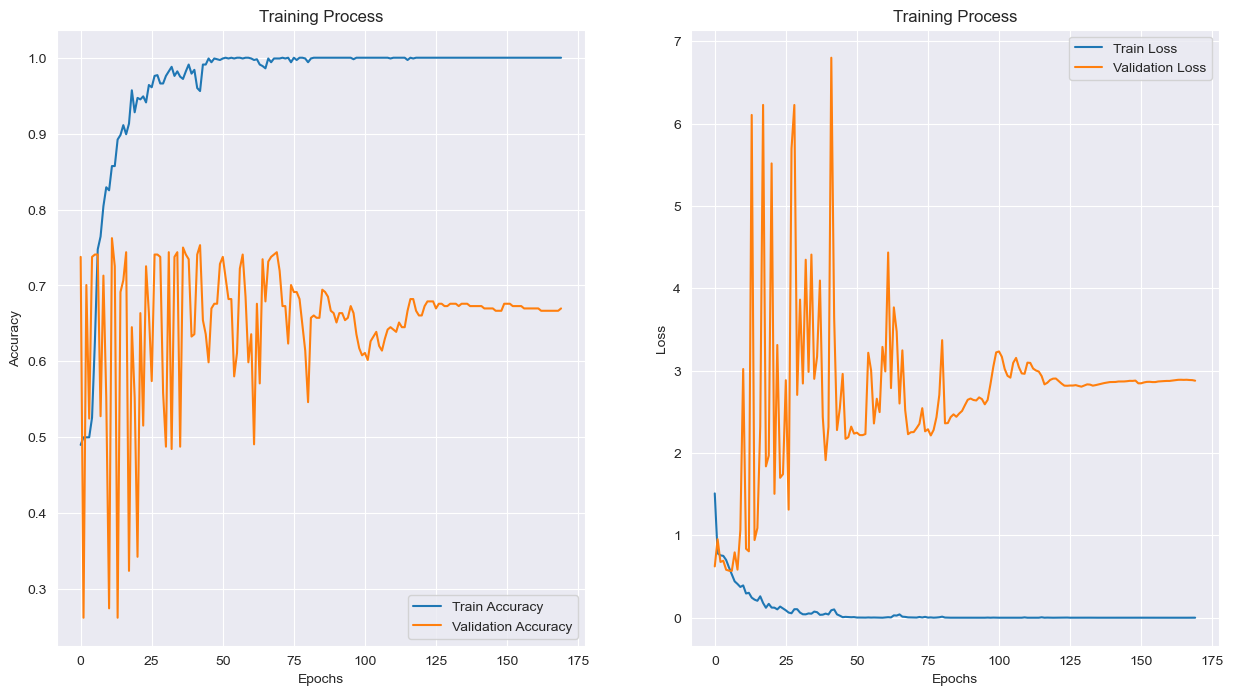

<Figure size 640x480 with 0 Axes>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [22]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 1s 6ms/step


0.7438271604938271

In [23]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7438271604938271
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.44      0.47        85
           0       0.81      0.85      0.83       239

    accuracy                           0.74       324
   macro avg       0.66      0.64      0.65       324
weighted avg       0.73      0.74      0.74       324



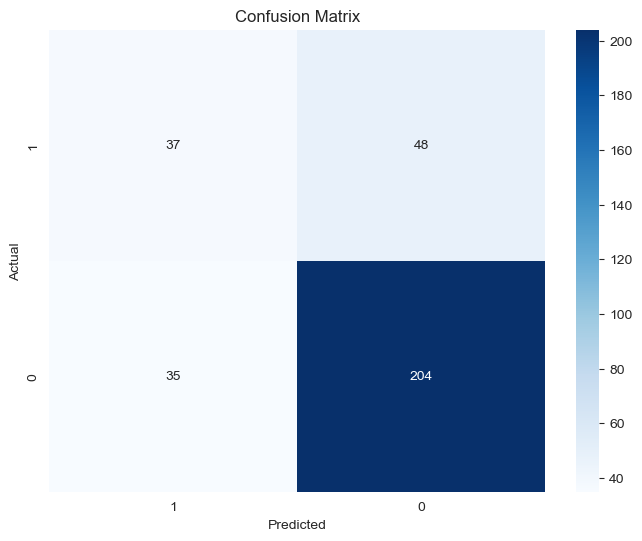

In [25]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

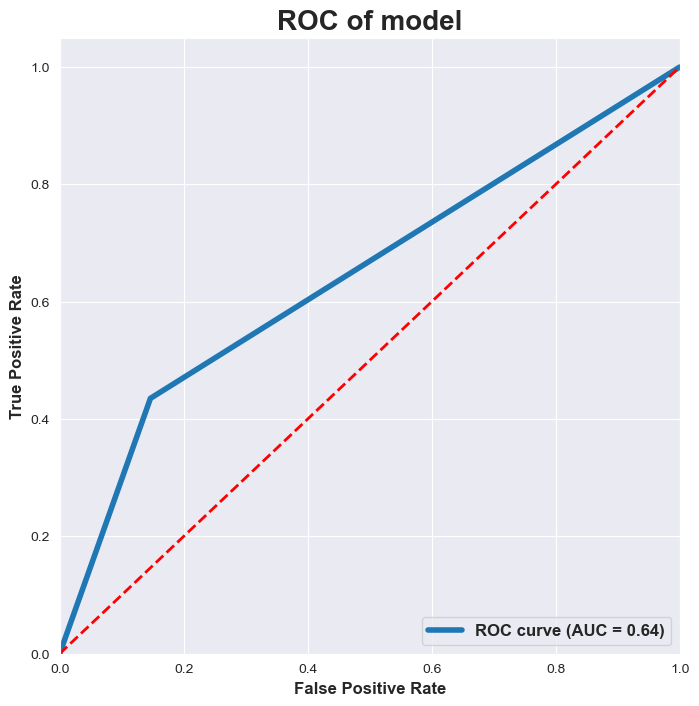

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [27]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [28]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------


In [29]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 241 chiếm khoảng 74.38271604938271% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 37 chiếm khoảng 43.529411764705884% so với thực tế
